In [ ]:
%env "WANDB_NOTEBOOK_NAME" "10_hetero_sine_weight_strat.ipynb"
%env WANDB_SILENT=True
%load_ext autoreload
%reload_ext autoreload
# %env XLA_PYTHON_CLIENT_MEM_FRACTION=0.3

env: "WANDB_NOTEBOOK_NAME"="10_hetero_sine_weight_strat.ipynb"
env: WANDB_SILENT=True
env: XLA_PYTHON_CLIENT_MEM_FRACTION=0.3


In [ ]:
import jax
import numpy as np
import jax.numpy as jnp
import equinox as eqx
import optax

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.style as mplstyle
import seaborn as sns

from NeuralNetworkEvolution.config import MLPConfig
from NeuralNetworkEvolution.activations import sin
from NeuralNetworkEvolution.mlp import CustomMLP, mlp_plot

import os
import sys
import logging
from tqdm.notebook import trange
import wandb

In [ ]:
plt.style.use('default')
sns.set_theme(context='paper', style='white', palette='viridis', font='serif',
            font_scale=2, color_codes=True, rc={'text.usetex' : True})
mplstyle.use('fast')

In [ ]:
input_size = 1
hidden_sizes = [5, 5] 
output_size = 1
initial_activation_list = [jax.nn.relu, jax.nn.tanh, sin]
activation_list = [jax.nn.relu, jax.nn.tanh, sin]
bias = False
num_epochs = 1000
add_node_every = 50
seed = 42
key = jax.random.PRNGKey(42)
threshold = 2e-4
n_samples = 2000
learning_rate = 0.01

config = MLPConfig(input_size=input_size,
                output_size=output_size,
                hidden_sizes=hidden_sizes,
                initial_activation_list=initial_activation_list,
                bias = bias,
                seed=seed)

2024-06-04 12:50:56.311467: W external/xla/xla/service/gpu/nvptx_compiler.cc:760] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.4.131). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [ ]:
config.__dict__.update({'n_samples': n_samples,
                        'learning_rate': learning_rate,
                        'num_epochs': num_epochs,
                        'add_node_every': add_node_every,
                        'threshold': threshold,
                        'activation_list': activation_list})

In [ ]:
# jax.config.update("jax_enable_x64", True)
jax.config.update('jax_platform_name', 'cpu')
Description = f"Hetero_sine_weight_strat_{hidden_sizes[0]}_{hidden_sizes[1]}_{num_epochs}_{add_node_every}_{threshold}_{seed}"
fig_folder = f"../figures/{Description}"
out_folder = f"../output/{Description}"
os.makedirs(fig_folder, exist_ok=True)
os.makedirs(out_folder, exist_ok=True)

In [ ]:
print(f"# devices: {jax.local_device_count()}")

logging.basicConfig(level=logging.INFO, filename=f"{out_folder}/info.log", filemode="w")
console = logging.StreamHandler(sys.stdout)
console.setLevel(logging.INFO)
logging.getLogger("").addHandler(console)
logging.info(f"Description: {Description}")
logging.info(f"jax backend: {jax.lib.xla_bridge.get_backend().platform}")
logging.info(f"jax devices: {jax.devices()}")

# devices: 4
Description: Hetero_sine_weight_strat_5_5_1000_50_0.0002_42
jax backend: cpu
jax devices: [cuda(id=0), cuda(id=1), cuda(id=2), cuda(id=3)]


In [ ]:
run = wandb.init(project="neural-network-evolution", name=Description, config=config.__dict__)


In [ ]:
def initialize_optimizer_state(mlp, optimizer):
    return optimizer.init(eqx.filter(mlp, eqx.is_inexact_array))

In [ ]:
mlp = CustomMLP(config)

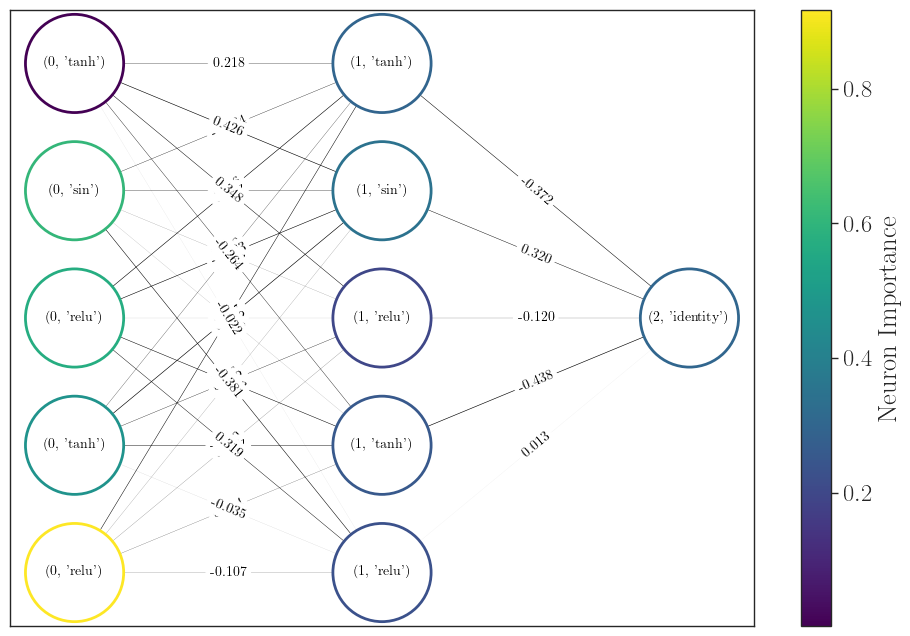

In [ ]:
G, neuron_labels, neuron_importances = mlp.visualize_graph()
fig = mlp_plot(G, neuron_labels, neuron_importances)
plt.savefig(f"{fig_folder}/initial_graph.png")
wandb.log({"initial neural network": wandb.Image(plt, caption="initial neural network")})

In [ ]:
@eqx.filter_value_and_grad()
def compute_loss(mlp, x, y):
    pred = jax.vmap(mlp)(x)
    return jnp.mean((pred - y) ** 2)

In [ ]:
@eqx.filter_jit()
def train_step(mlp, x, y, opt_state, opt_update):
    loss, grads = compute_loss(mlp, x, y)
    updates, opt_state = opt_update(grads, opt_state)
    mlp = eqx.apply_updates(mlp, updates)
    return loss, mlp, opt_state

In [ ]:
x = jnp.linspace(0, 2*jnp.pi, n_samples).reshape(-1, 1)
y = jnp.sin(x)

In [ ]:
opt = optax.adabelief(learning_rate=learning_rate)
opt_state = initialize_optimizer_state(mlp, opt)

In [ ]:
initial_adjacency_matrix = mlp.adjacency_matrix()

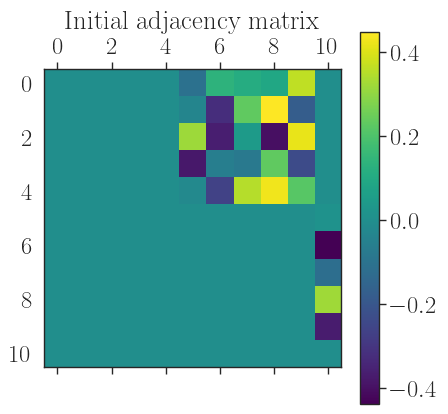

In [ ]:
plt.matshow(initial_adjacency_matrix, cmap=plt.cm.viridis)
plt.colorbar()
plt.title("Initial adjacency matrix")
plt.savefig(f"{fig_folder}/initial_adjacency_matrix.png")
wandb.log({"initial adjacency matrix": wandb.Image(plt, caption="initial adjacency matrix")})

In [ ]:
Loss_history = []
Node_history = []
graph_history = []
Update_history = []

In [ ]:
for epoch in range(num_epochs):
    loss, mlp, opt_state = train_step(mlp, x, y, opt_state, opt.update)
    print(f"Epoch {epoch}, Loss: {loss}")

    key, add_key, sub_key = jax.random.split(key,3)
    n_neurons = sum(mlp.get_shape())
    logging.info(f"Epoch {epoch :03d}, Loss: {loss.item()}, Neurons: {n_neurons}")
    wandb.log({"loss": loss.item(), "neurons": n_neurons})
    Loss_history.append(loss)
    Node_history.append(n_neurons)

    if loss < threshold:
        # if loss is below threshold, stop training
        logging.info(f"Threshold reached, stopping training at epoch {epoch}")
        wandb.log({"threshold reached": epoch})
        break

    # Dynamically add or remove neurons
    if (epoch + 1) % add_node_every == 0:

        # add criterion
        if len(Update_history) == 0 or Update_history[-1][2] > loss:
            # if no previous addition add a neuron
            # if last addition was accepted, add a neuron
            add_key, act_key = jax.random.split(add_key)
            activation = activation_list[jax.random.choice(key, jnp.arange(len(activation_list)))]
            layer = mlp.most_important_layer()
            mlp.add_neuron(layer_index=layer, activation=activation, bias=bias, key=act_key)
            opt_state = initialize_optimizer_state(mlp, opt)

            Update_history.append((epoch, n_neurons, loss, activation.__name__, layer))
            logging.info(f"Added neuron to hidden layer {layer+1} with activation {activation.__name__}")
            wandb.log({"added neuron": activation.__name__})
            logging.info(f"network shape updated to :{mlp.get_shape()}")
        
        # remove criteria
        elif (Update_history[-1][3] == "removed" and Update_history[-2][2] < loss) or \
            (Update_history[-1][3] != "removed" and Update_history[-1][2] < loss):
            # if last addition was removed check loss against value before that
            # if last addition was accepted, check loss against it
            # if loss doesn't improve, reject it

            layer, neuron_idx = mlp.least_important_neuron()

            mlp.remove_neuron(layer_index=layer, neuron_index=neuron_idx)
            opt_state = initialize_optimizer_state(mlp, opt)
            Update_history.append((epoch, n_neurons, loss, "removed", layer))

            logging.info(f"Removed neuron to hidden layer {layer+1} at index {neuron_idx}")
            wandb.log({"removed neuron": neuron_idx})
            logging.info(f"network shape updated to :{mlp.get_shape()}")
        




Epoch 0, Loss: 0.6745333454215698
Epoch 000, Loss: 0.6745333454215698, Neurons: 11
Epoch 1, Loss: 0.6468370837994296
Epoch 001, Loss: 0.6468370837994296, Neurons: 11
Epoch 2, Loss: 0.620789509782109
Epoch 002, Loss: 0.620789509782109, Neurons: 11
Epoch 3, Loss: 0.5964148256308994
Epoch 003, Loss: 0.5964148256308994, Neurons: 11
Epoch 4, Loss: 0.5739995098591668
Epoch 004, Loss: 0.5739995098591668, Neurons: 11
Epoch 5, Loss: 0.5537587596373554
Epoch 005, Loss: 0.5537587596373554, Neurons: 11
Epoch 6, Loss: 0.5357849762893075
Epoch 006, Loss: 0.5357849762893075, Neurons: 11
Epoch 7, Loss: 0.5200308758034188
Epoch 007, Loss: 0.5200308758034188, Neurons: 11
Epoch 8, Loss: 0.5063276718353082
Epoch 008, Loss: 0.5063276718353082, Neurons: 11
Epoch 9, Loss: 0.4944320503777467
Epoch 009, Loss: 0.4944320503777467, Neurons: 11
Epoch 10, Loss: 0.48408472000791797
Epoch 010, Loss: 0.48408472000791797, Neurons: 11
Epoch 11, Loss: 0.47506003071820113
Epoch 011, Loss: 0.47506003071820113, Neurons: 11


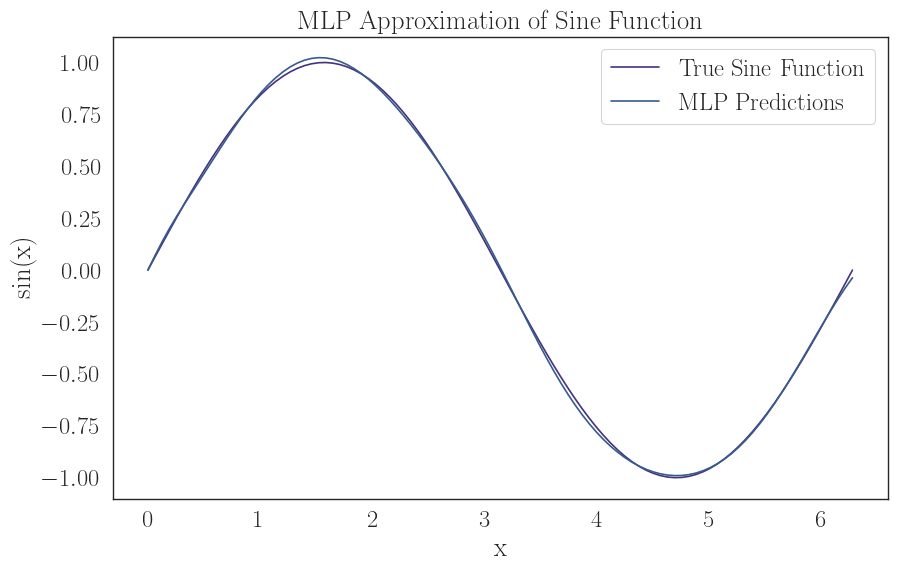

In [ ]:
x_test = jnp.linspace(0, 2*jnp.pi, 100).reshape(-1, 1)
y_test = jnp.sin(x_test)
y_pred = jax.vmap(mlp)(x_test)

plt.figure(figsize=(10, 6))
plt.plot(x_test, y_test, label="True Sine Function")
plt.plot(x_test, y_pred, label="MLP Predictions")
plt.legend()
plt.xlabel("x")
plt.ylabel("sin(x)")
plt.title("MLP Approximation of Sine Function")
plt.savefig(f"{fig_folder}/sine_approximation.png")
wandb.log({"sine approximation": wandb.Image(plt, caption="sine approximation")})


In [ ]:
Update_history

[(49, 11, Array(0.05239367, dtype=float64), 'sin', Array(0, dtype=int64)),
 (99, 12, Array(0.00045389, dtype=float64), 'tanh', Array(0, dtype=int64)),
 (149, 13, Array(0.00037928, dtype=float64), 'relu', Array(0, dtype=int64)),
 (199, 14, Array(0.06658463, dtype=float64), 'removed', Array(0, dtype=int32)),
 (249, 13, Array(0.00795226, dtype=float64), 'relu', Array(0, dtype=int64)),
 (299, 14, Array(0.00127586, dtype=float64), 'sin', Array(1, dtype=int64)),
 (349, 15, Array(0.00181906, dtype=float64), 'removed', Array(0, dtype=int32)),
 (399, 14, Array(0.00225631, dtype=float64), 'removed', Array(0, dtype=int32)),
 (449, 13, Array(0.00021167, dtype=float64), 'tanh', Array(0, dtype=int64)),
 (499, 14, Array(0.00594557, dtype=float64), 'removed', Array(0, dtype=int32))]

In [ ]:
final_adjacency_matrix = mlp.adjacency_matrix()

In [ ]:
np.savetxt(f"{out_folder}/final_adjacency_matrix.txt", final_adjacency_matrix)

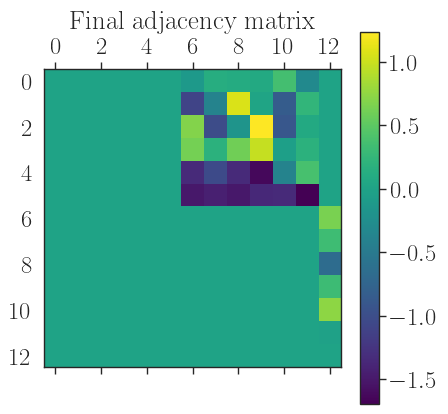

In [ ]:
plt.matshow(final_adjacency_matrix, cmap=plt.cm.viridis)
plt.colorbar()
plt.title("Final adjacency matrix")
plt.savefig(f"{fig_folder}/final_adjacency_matrix.png")
wandb.log({"final adjacency matrix": wandb.Image(plt, caption="final adjacency matrix")})

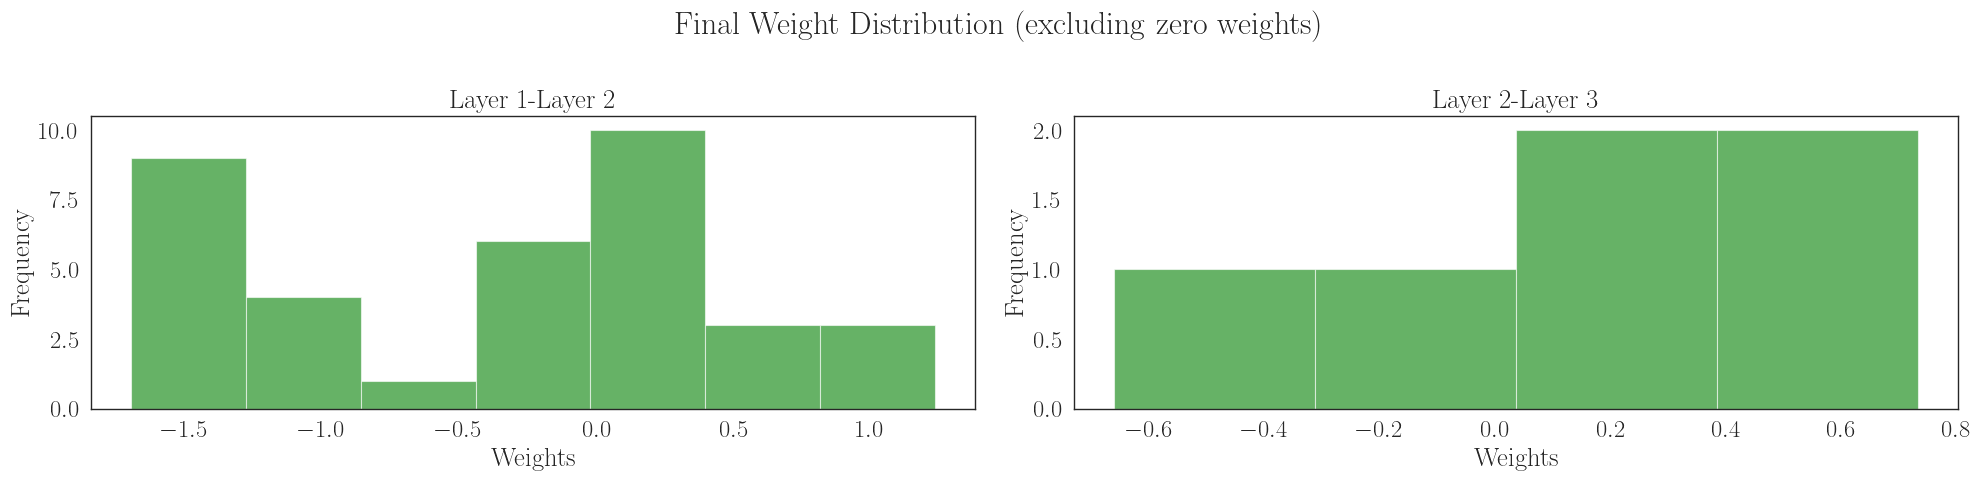

In [ ]:
sub_matrices = np.split(final_adjacency_matrix, np.cumsum(mlp.get_shape())[:-1])[:-1]

fig, axs = plt.subplots(1, len(sub_matrices), figsize=(20, 5))

for i, (sub_matrix, ax) in enumerate(zip(sub_matrices, axs), start=1):
    weights = sub_matrix.flatten()
    weights = weights[weights != 0]
    ax.hist(weights, bins="auto", density=False, alpha=0.6, color='g')
    ax.set_xlabel('Weights')
    ax.set_ylabel('Frequency')
    ax.set_title(f'Layer {i}-Layer {i+1} ')

# Display the figure with its subplots
plt.suptitle('Final Weight Distribution (excluding zero weights)')
plt.tight_layout()
plt.show()

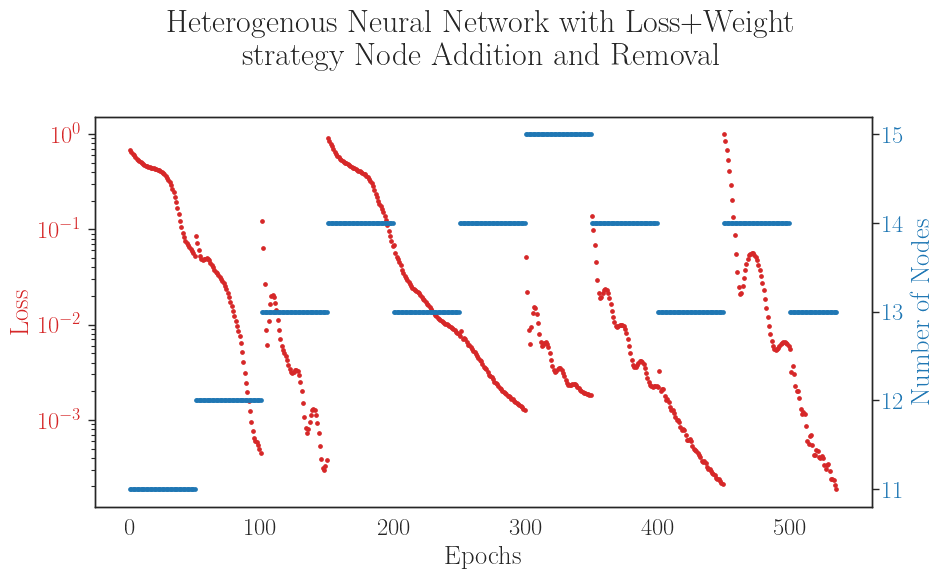

In [ ]:
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:red'
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss', color=color)
ax1.plot(np.arange(0,len(Loss_history)), Loss_history, ".", color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_yscale("log")

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Number of Nodes', color=color)  # we already handled the x-label with ax1
ax2.plot(np.arange(0,len(Node_history)), Node_history, ".", color=color)
ax2.tick_params(axis='y', labelcolor=color)
plt.suptitle("Heterogenous Neural Network with Loss+Weight\n strategy Node Addition and Removal")
fig.tight_layout()

plt.savefig(f"{fig_folder}/loss_curve.png")
wandb.log({"loss and nodes": wandb.Image(plt, caption="loss and nodes")})

In [ ]:
# save neurons and loss curve
np.savetxt(f"{out_folder}/neurons.txt", Node_history)
np.savetxt(f"{out_folder}/loss.txt", Loss_history)

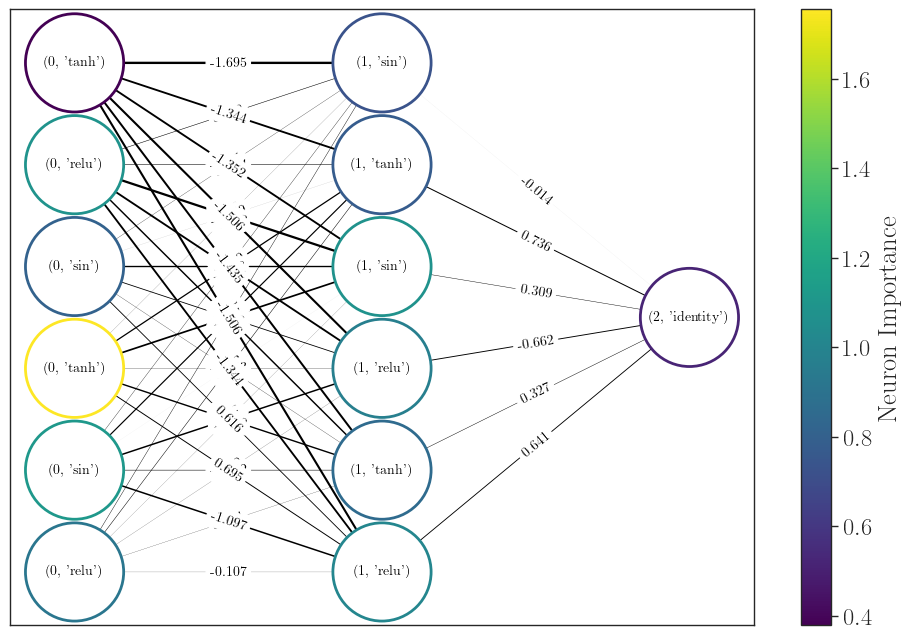

In [ ]:
G, neuron_labels, neuron_importances = mlp.visualize_graph()
fig = mlp_plot(G, neuron_labels, neuron_importances)
plt.savefig(f"{fig_folder}/final_graph.png")
wandb.log({"final neural network": wandb.Image(plt, caption="final neural network")})

In [ ]:
wandb.finish()